In [7]:
!pip install kaggle --quiet

In [8]:
import pandas as pd
import numpy as np
import re
import nltk
import string

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

# =======================================
# 2. Mount Google Drive (if dataset is in Drive)
# =======================================
from google.colab import drive
drive.mount('/content/drive')

# Example path (adjust if your dataset is in another folder)
dataset_path = "/content/drive/MyDrive/IMDB Dataset.csv"

# =======================================
# 3. Load Dataset
# =======================================
df = pd.read_csv(dataset_path)

# Show first 5 rows
print("Dataset Shape:", df.shape)
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [9]:

# =======================================
# 4. Check Class Distribution
# =======================================
print("\nClass Distribution:")
print(df['sentiment'].value_counts())

# Convert sentiment to numeric: positive → 1, negative → 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# =======================================
# 5. Preprocessing Function
# =======================================
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove numbers
    text = re.sub(r"\d+", " ", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    # Remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

# Apply preprocessing
df['clean_review'] = df['review'].apply(preprocess_text)

# =======================================
# 6. Show Processed Data
# =======================================
print("\nSample after preprocessing:")
print(df[['review', 'clean_review', 'sentiment']].head())


Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Sample after preprocessing:
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                        clean_review  sentiment  
0  one reviewers mentioned watching oz episode yo...          1  
1  wonderful little production filming technique ...          1  
2  thought wonderful way spend time hot summer we...          1  
3  basically theres family little boy jake thinks...          0  
4  petter matteis love time money visually stunni...          1  


In [10]:
# =======================================
# 1. Install & Import PyTorch
# =======================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Check if CUDA is available

# ✅ Define device here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    print("✅ CUDA is available")
    print("Number of GPUs:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("❌ No GPU found, using CPU")

# =======================================
# 2. Tokenization + Padding
# =======================================
MAX_WORDS = 10000   # keep top 10k words
MAX_LEN = 200       # max words per review

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_review'])

X = tokenizer.texts_to_sequences(df['clean_review'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')
y = df['sentiment'].values

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# =======================================
# 3. Train-Test Split
# =======================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to Torch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

# DataLoader (for batching)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# =======================================
# 4. Build a Simple LSTM Model
# =======================================
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

model = SentimentModel(vocab_size=MAX_WORDS, embed_dim=128, hidden_dim=128, output_dim=1)
model.to(device)

# =======================================
# 5. Loss + Optimizer
# =======================================
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =======================================
# 6. Training Loop
# =======================================
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

print("✅ Training complete!")


Using device: cuda
✅ CUDA is available
Number of GPUs: 1
GPU 0: Tesla T4
Shape of X: (50000, 200)
Shape of y: (50000,)
Epoch 1/3, Loss: 0.6932
Epoch 2/3, Loss: 0.6824
Epoch 3/3, Loss: 0.4870
✅ Training complete!


In [11]:
import threading
import time
import matplotlib.pyplot as plt

# =======================================
# 2. Define Train Function
# =======================================
def train_model(hidden_dim, results_dict, key):
    model = SentimentModel(vocab_size=MAX_WORDS, embed_dim=128, hidden_dim=hidden_dim, output_dim=1)
    model.to("cpu")   # Force CPU for task parallelism
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start = time.time()
    for epoch in range(2):  # keep small for demo
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to("cpu"), y_batch.to("cpu")

            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"[Model {hidden_dim}] Epoch {epoch+1}, Loss={total_loss/len(train_loader):.4f}")
    end = time.time()

    results_dict[key] = end - start

# =======================================
# 3. Task Parallelism with Threads
# =======================================
results = {}

# Launch two threads: training two models with different hidden_dim
t1 = threading.Thread(target=train_model, args=(64, results, "Model-64"))
t2 = threading.Thread(target=train_model, args=(128, results, "Model-128"))

start_cpu = time.time()
t1.start()
t2.start()
t1.join()
t2.join()
end_cpu = time.time()

print("\nTask Parallelism (CPU Multi-threading) completed!")
print("Individual runtimes:", results)
print("Total CPU parallel runtime:", end_cpu - start_cpu)

[Model 64] Epoch 1, Loss=0.6930
[Model 64] Epoch 2, Loss=0.6846
[Model 128] Epoch 1, Loss=0.6935
[Model 128] Epoch 2, Loss=0.6895

Task Parallelism (CPU Multi-threading) completed!
Individual runtimes: {'Model-64': 405.2075443267822, 'Model-128': 984.9243006706238}
Total CPU parallel runtime: 984.9488835334778


In [12]:

# =======================================
# 4. GPU Training Runtime (for comparison)
# =======================================
def gpu_training():
    model = SentimentModel(vocab_size=MAX_WORDS, embed_dim=128, hidden_dim=128, output_dim=1)
    model.to("cuda")
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start = time.time()
    for epoch in range(2):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")

            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[GPU] Epoch {epoch+1}, Loss={total_loss/len(train_loader):.4f}")
    end = time.time()
    return end - start

gpu_time = gpu_training()
print("\nGPU runtime:", gpu_time)


[GPU] Epoch 1, Loss=0.6925
[GPU] Epoch 2, Loss=0.6150

GPU runtime: 8.79768967628479


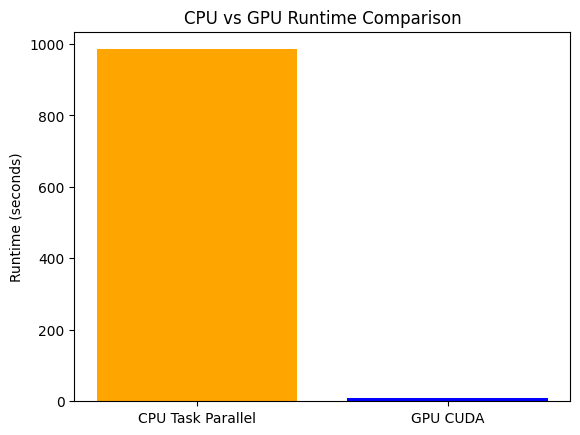

In [13]:
# =======================================
# 5. Plot CPU vs GPU Runtimes
# =======================================
labels = ["CPU Task Parallel", "GPU CUDA"]
times = [end_cpu - start_cpu, gpu_time]

plt.bar(labels, times, color=["orange", "blue"])
plt.ylabel("Runtime (seconds)")
plt.title("CPU vs GPU Runtime Comparison")
plt.show()